# Recommender System using Pyspark and ALS

Na série de artigos que escrevi, foi implementado um data lake que processa dados brutos passando pelas zonas source (Bronze), Landing (Silver) and Curated (Gold). Fizemos isso utilizando como exemplo a base da reviews de video game da AWS, nesse link. Agora, como próxima etapa, usaremos a base curada para implementarmos um sistema de recomendação. Com a implementação bem-sucedida do sistema de recomendação, os usuários da plataforma de reviews de video game da AWS poderão desfrutar de uma experiência mais personalizada, descobrindo novos jogos relevantes e, ao mesmo tempo, aumentando o envolvimento com a plataforma.

## Paradigmas de Recomendação

Existem várias abordagens possíveis para a construção de um sistema de recomendação, mas aqui vamos explorar duas das principais técnicas utilizadas: filtragem colaborativa e filtragem baseada em conteúdo.

### Filtragem Colaborativa:
A filtragem colaborativa utiliza o comportamento coletivo de usuários para fazer recomendações. É baseada na ideia de que se dois usuários tiverem interesses semelhantes no passado, é provável que compartilhem interesses em jogos futuros. Esse método requer um conjunto de dados extenso e denso, o que geralmente é o caso das bases de reviews de video game. De maneira geral, o processo envolve os seguintes passos:
Matriz de avaliações: Construir uma matriz em que as linhas representam os usuários, as colunas representam os jogos e os valores representam as avaliações dadas pelos usuários aos jogos.

- ***Similaridade entre usuários***: Calcular a similaridade entre os usuários com base nas suas avaliações. Existem várias métricas para medir a similaridade, como a distância euclidiana ou a correlação de Pearson.

 - ***Seleção de vizinhos***: Identificar os usuários mais similares ao usuário-alvo com base na similaridade calculada.

 - ***Geração de recomendações***: Com base nos jogos avaliados pelos usuários vizinhos, recomendar jogos que ainda não foram avaliados pelo usuário-alvo.
 
Algoritmos de filtragem colaborativa, como ALS, SVD ou até mesmo soluções usando redes neurais, criam um embedding para cada usuário e item, um vetor que permite avaliar similaridades, gerando recomendações bastante assertivas. 

### Filtragem Baseada em Conteúdo:
A filtragem baseada em conteúdo se concentra nas características dos próprios jogos e nos interesses declarados dos usuários. Ela requer informações detalhadas sobre os jogos, como gênero, tema, estilo de jogo, gráficos, entre outros. Os passos para implementar essa abordagem são os seguintes:
- ***Extração de características***: Analisar e extrair informações relevantes dos metadados dos jogos para criar um perfil de características de cada um.

- ***Perfil do usuário***: Construir o perfil de preferências de cada usuário com base nas avaliações e preferências anteriores.

- ***Similaridade entre jogos***: Calcular a similaridade entre os jogos com base em suas características. Isso pode ser feito usando técnicas como similaridade de cosseno ou índice Jaccard.

- ***Geração de recomendações***: Recomendar jogos que compartilham características semelhantes com os jogos bem avaliados pelo usuário.

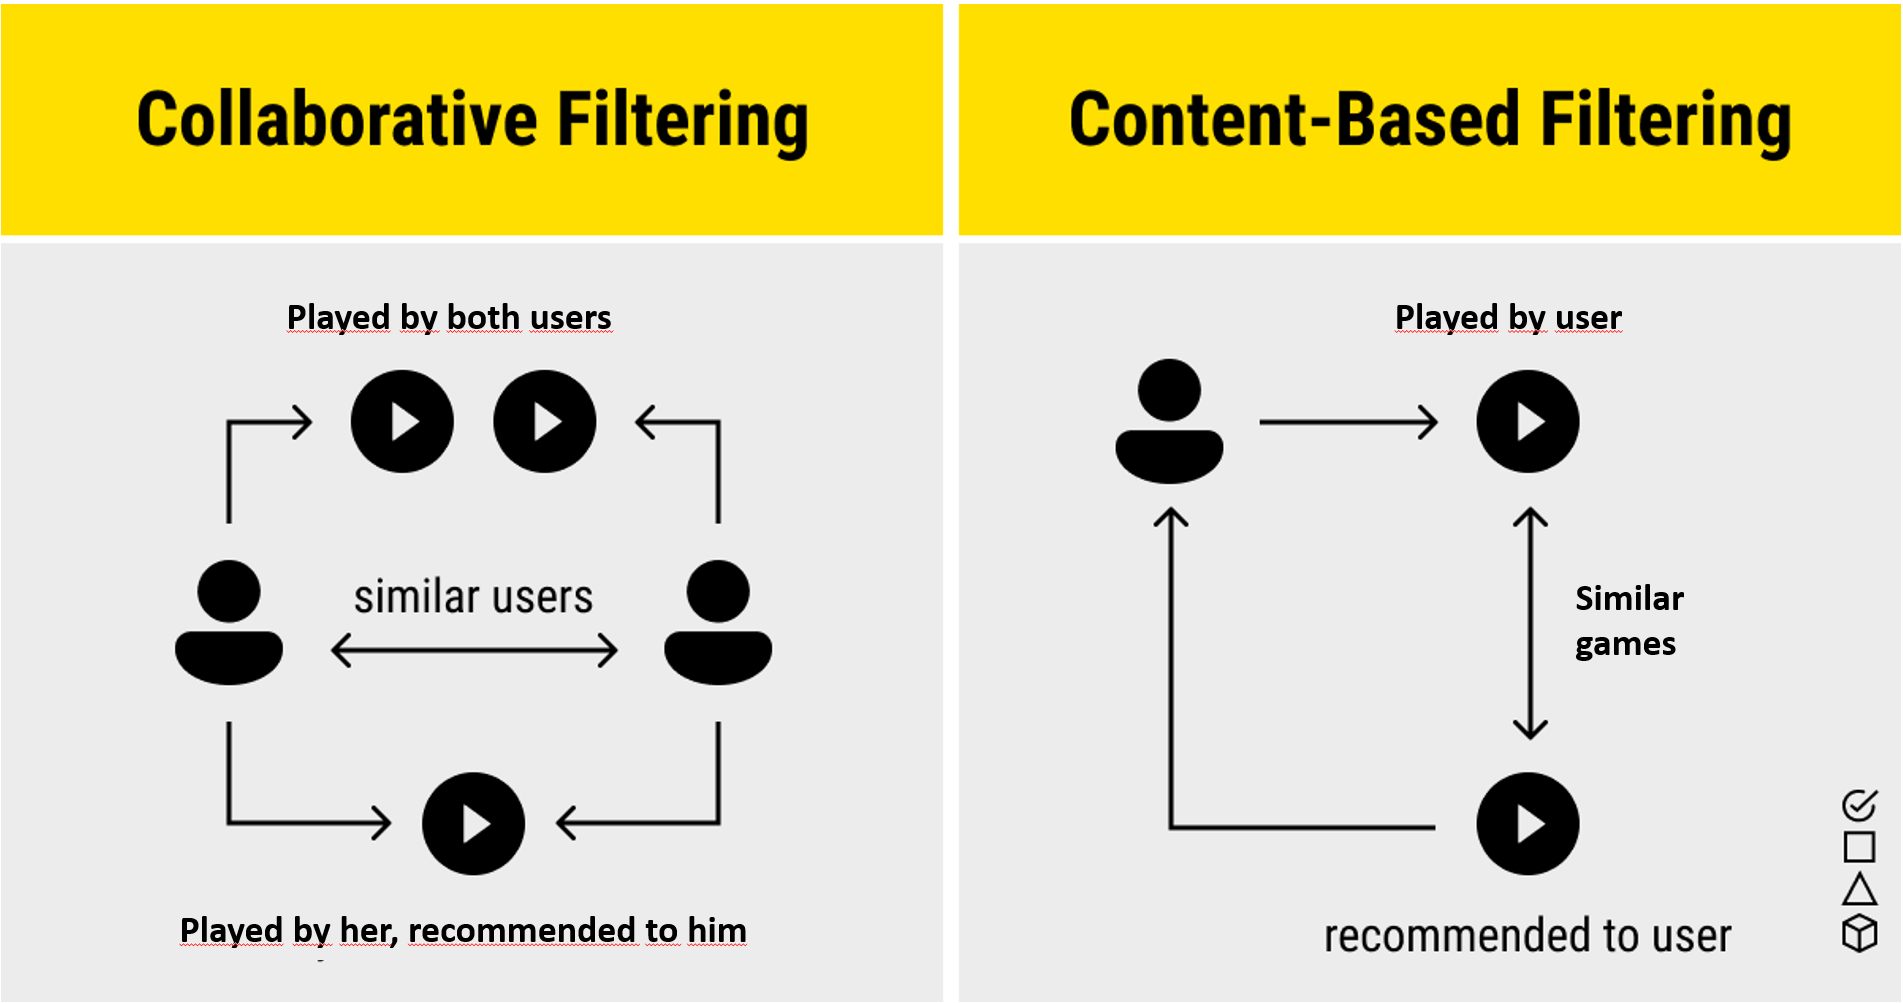

Recomenda-se usar filtragem colaborativa quando temos um grande número de usuários e itens, mas as avaliações fornecidas pelos usuários são esparsas. Nesses casos, é difícil obter informações suficientes sobre as características dos itens e a filtragem baseada em conteúdo se torna menos eficaz. Quando temos informações detalhadas sobre os itens disponíveis, a filtragem baseada em conteúdo pode ser muito eficaz. Ela aproveita essas informações para fazer recomendações personalizadas com base nas características que os usuários demonstraram gostar no passado. Outro vantagem são os novos usuários: A filtragem baseada em conteúdo é útil quando temos novos usuários sem histórico de avaliações. Ela pode começar a fazer recomendações imediatamente com base nas características dos itens que são mais relevantes para os usuários com base em suas preferências declaradas.

Muitos sistemas de recomendação utilizam abordagens híbridas que combinam elementos da filtragem colaborativa e da filtragem baseada em conteúdo para obter melhores resultados de recomendação. A filtragem colaborativa e a filtragem baseada em conteúdo têm suas próprias vantagens e limitações, e a combinação das duas pode compensar as fraquezas de cada uma, fornecendo recomendações mais precisas e diversificadas.

### Recomendação implícita e explícita

As recomendações podem ser classificadas em dois tipos principais com base na forma como são obtidas a partir das interações dos usuários com o sistema: recomendação explícita e recomendação implícita.
- Recomendação Explícita:
Na recomendação explícita, os usuários fornecem avaliações ou feedback direto sobre os itens, indicando explicitamente suas preferências. É o caso da base de jogos da AWS: os usuários podem atribuir uma classificação ou estrelas apósjogá-lo, indicando sua opinião sobre a obra. 
Tem a vantagem de ser mais fácil de interpretar, pois representam as opiniões diretas dos usuários, mas nem todos os usuários fornecem avaliações explícitas para todos os itens, o que pode levar a uma matriz de avaliações esparsa.
- Recomendação Implícita:
Na recomendação implícita, os dados são coletados a partir do comportamento implícito dos usuários, como cliques, compras, tempo gasto em páginas, histórico de visualização, entre outros. Esses comportamentos podem indicar o interesse do usuário em um item, mesmo que não haja uma avaliação ou feedback direto. Por exemplo, em um serviço de streaming de músicas, os cliques frequentes em certas músicas ou artistas podem ser usados para inferir o interesse do usuário em relação a esses itens.
Tem a vantagem de menos dependência de feedback direto e dados mais abundantes, porém as interações implícitas podem não fornecer detalhes suficientes sobre as preferências específicas do usuário, tornando as recomendações menos personalizadas.

### Explorando a base de dados

Faremos inicialmente uma exploração da base de reviews de video games da AWS. A base curada usada nesse artigo pode ser baixada nesse link.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, countDistinct, count
from pyspark.sql.window import Window
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
import pandas as pd

spark = SparkSession.builder.appName(
    'video_games_review').config("spark.driver.memory", "15g").getOrCreate()

df_landing = pd.read_parquet('video_games_review_landing.parquet')
spark_df_landing =  spark.createDataFrame(df_landing) 

In [2]:
spark_df_landing.show(vertical=True)

-RECORD 0--------------------------------
 Format_style     | null                 
 Edition_style    | null                 
 Platform_style   | null                 
 Color_style      | null                 
 number_of_images | 0                    
 reviewTime       | 2015-10-17 00:00:00  
 overall          | 5                    
 verified         | true                 
 reviewerID       | A1HP7NVNPFMA4N       
 asin             | 0700026657           
 reviewerName     | Ambrosia075          
 reviewText       | This game is a bi... 
 summary          | but when you do i... 
 unixReviewTime   | 1445040000           
 vote             | NaN                  
-RECORD 1--------------------------------
 Format_style     | null                 
 Edition_style    | null                 
 Platform_style   | null                 
 Color_style      | null                 
 number_of_images | 0                    
 reviewTime       | 2015-07-27 00:00:00  
 overall          | 4             

Basicamente, precisamos de três colunas para treinar nosso algoritmo de recomendação usando filtragem colaborativa:
- userid - ID do usuário
- ItemId - Id do item
- rating - nota que o usuário deu para ao avaliar o item

In [3]:
df_rec = spark_df_landing.select('reviewerID', 'asin', 'overall').withColumnRenamed("reviewerID","userId")\
                                                                 .withColumnRenamed("asin","itemId")\
                                                                 .withColumnRenamed("overall","rating")

df_rec = df_rec.orderBy("userId", "itemId")

Ao treinar um algoritmo e fazer avaliações de perfomance mais assertiva, pode ser interessante limitar a quantidade de itens, já que muitos são avaliados poucas vezes, e sua recomendação é imprecisa. Aqui selecionaremos somente os 500 itens mais populares da base. Também seria impreciso fazer recomendações para usuários com poucos itens avaliados, portanto filtraremos a base somente com usuários que tenham avaliado mais de 10 itens.

In [4]:
popularity_df = df_rec.groupBy('itemId') \
                 .agg(count('*').alias('popularity')) \
                 .orderBy(col('popularity').desc())

# Select the top 10 most popular items
top_popular_items = popularity_df.limit(500)
df_rec_filtered = df_rec.join(top_popular_items, on='itemId', how='inner')

# Criar uma coluna com a contagem de itens por usuário
user_window = Window.partitionBy("userId").orderBy(col("itemId").desc())
df_rec_filtered = df_rec_filtered.withColumn("num_items", expr("count(*) over (partition by userId)"))
df_rec_filtered = df_rec_filtered.filter(col("num_items")>=5)

E aqui temos a quantidade de itens e usuários na nossa base filtrada:

In [5]:
# Count the number of unique items
num_unique_items = df_rec_filtered.select('itemId').distinct().count()
print(f"Number of unique items: {num_unique_items}")

# Count the number of unique users
num_unique_users = df_rec_filtered.select('userId').distinct().count()
print(f"Number of unique users: {num_unique_users}")


Number of unique items: 500
Number of unique users: 7493


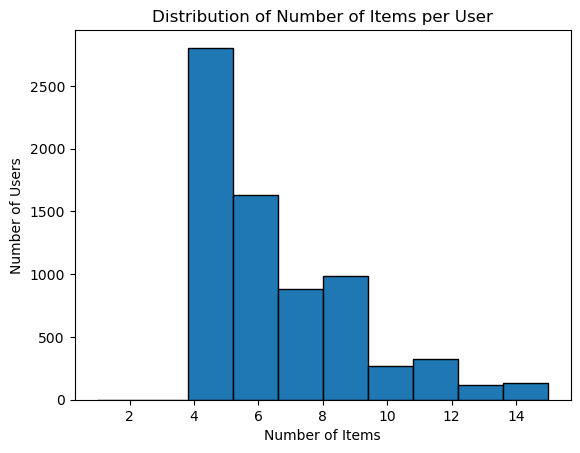

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

items_per_user = df_rec_filtered.groupBy('userId').count().select('count').toPandas()


# Plot the histogram
plt.hist(items_per_user['count'], bins=10, range=(1,15), edgecolor='black')
plt.xlabel('Number of Items')
plt.ylabel('Number of Users')
plt.title('Distribution of Number of Items per User')
plt.show()

### Divisão entre treino e teste

Geralmente quando treinamenos algoritmos de machine learning, dividimos a base entre treino e teste simplesmente selecionando uma fração de dados para treino e teste de maneira randomizada. Para uma base de recomendação, temos que fazer algo um pouco diferente, já que é necessário ter, tanto na base de treino quanto na de teste, todos os usuários da base. Devemos mascarar uma porcentagem de itens de cada usuário. Vamos ocultar 20% dos itens de cada usuário e, para testar nosso sistema de recomendação, usaremos métricas como precisão e NDCG para comparar os resultados da previsão com os itens que foram ocultados.   

In [7]:
# Por exemplo,30% dos itens serão mascarados
percent_items_to_mask = 0.3 
# Determinar o número de itens a serem mascarados para cada usuário
df_rec_final = df_rec_filtered.withColumn("num_items_to_mask", (col("num_items") * percent_items_to_mask).cast("int"))
# Mascara os itens para cada usuário
df_rec_final = df_rec_final.withColumn("item_rank", rank().over(user_window))

# Create a StringIndexer model to index the user ID column
indexer_user = StringIndexer(inputCol='userId', outputCol='userIndex').setHandleInvalid("keep")
indexer_item = StringIndexer(inputCol='itemId', outputCol='itemIndex').setHandleInvalid("keep")

# Fit the indexer model to the data and transform the DataFrame
df_rec_final = indexer_user.fit(df_rec_final).transform(df_rec_final)
df_rec_final = indexer_item.fit(df_rec_final).transform(df_rec_final)

# Convert the userIndex column to integer type
df_rec_final = df_rec_final.withColumn('userIndex', df_rec_final['userIndex'].cast('integer'))\
               .withColumn('itemIndex', df_rec_final['itemIndex'].cast('integer'))

train_df_rec = df_rec_final.filter(col("item_rank") > col("num_items_to_mask"))
test_df_rec = df_rec_final.filter(col("item_rank") <= col("num_items_to_mask"))

In [8]:
train_df_rec.count()

42732

In [9]:
test_df_rec.count()

13745

In [10]:
train_df_rec.show()

+----------+--------------------+------+----------+---------+-----------------+---------+---------+---------+
|    itemId|              userId|rating|popularity|num_items|num_items_to_mask|item_rank|userIndex|itemIndex|
+----------+--------------------+------+----------+---------+-----------------+---------+---------+---------+
|B00BGAA3S2|A0380485C177Q6QQNJIX|     5|       425|        6|                1|        2|     3055|       51|
|B00BGA9YZK|A0380485C177Q6QQNJIX|     5|       543|        6|                1|        3|     3055|       12|
|B006PP41Q8|A0380485C177Q6QQNJIX|     5|       153|        6|                1|        4|     3055|      405|
|B006JKASCK|A0380485C177Q6QQNJIX|     5|       301|        6|                1|        5|     3055|      227|
|B000FQ2D5E|A0380485C177Q6QQNJIX|     5|       432|        6|                1|        6|     3055|       22|
|B00BMFIXOW|      A102SVOH0JD2RP|     5|       407|        8|                2|        3|     1570|       34|
|B003R7H5T

### Alternated Least Squares (ALS)

O Spark tem implementado o ALS, um algoritmo amplamente utilizado na implementação de sistemas de recomendação baseados em Filtragem Colaborativa. Ele aborda o problema de recomendação como uma matriz de fatorização, onde as avaliações dadas pelos usuários a diferentes itens (jogos, no nosso caso) são representadas como uma matriz esparsa. Vamos entender passo-a-passo como esse algoritmo funciona:

#### Matriz de avaliações:
Inicialmente, construímos uma matriz que representa as avaliações dos usuários para os jogos. Cada linha da matriz representa um usuário, cada coluna representa um jogo e os valores preenchidos representam as avaliações dadas pelos usuários aos jogos (ou "NaN" para indicar que o usuário não avaliou um determinado jogo).

#### Fatorização da matriz:
O ALS aborda a matriz de avaliações como o produto de duas matrizes menores: uma matriz de usuários e uma matriz de itens (jogos). Essa fatorização tem como objetivo encontrar os "vetores latentes" que representam as características ocultas dos usuários e dos itens.

Suponha que temos uma matriz R de avaliações de usuários para itens (jogos) onde as linhas representam os usuários, as colunas representam os itens e os valores representam as avaliações dadas pelos usuários aos itens (ou "NaN" para indicar que o usuário não avaliou o item). O objetivo é encontrar duas matrizes menores, P e Q, cujo produto se aproxime o máximo possível da matriz R original, ou seja, encontrar as predições $\hat{r}_{ij}$ que se aproximem o máximo possivel das avaliações reais $r_{ij}$ da matriz R.
A função de perda que queremos minimizar é dada pela soma dos quadrados dos erros entre as predições e as avaliações reais:
$$Loss = \sum_{(i,j)\in \Omega}\left (r_{ij}-\hat{r}_{ij} \right )^{2}$$
onde $\Omega$ é o conjunto de pares de índices (i, j) correspondentes a avaliações conhecidas na matriz R.

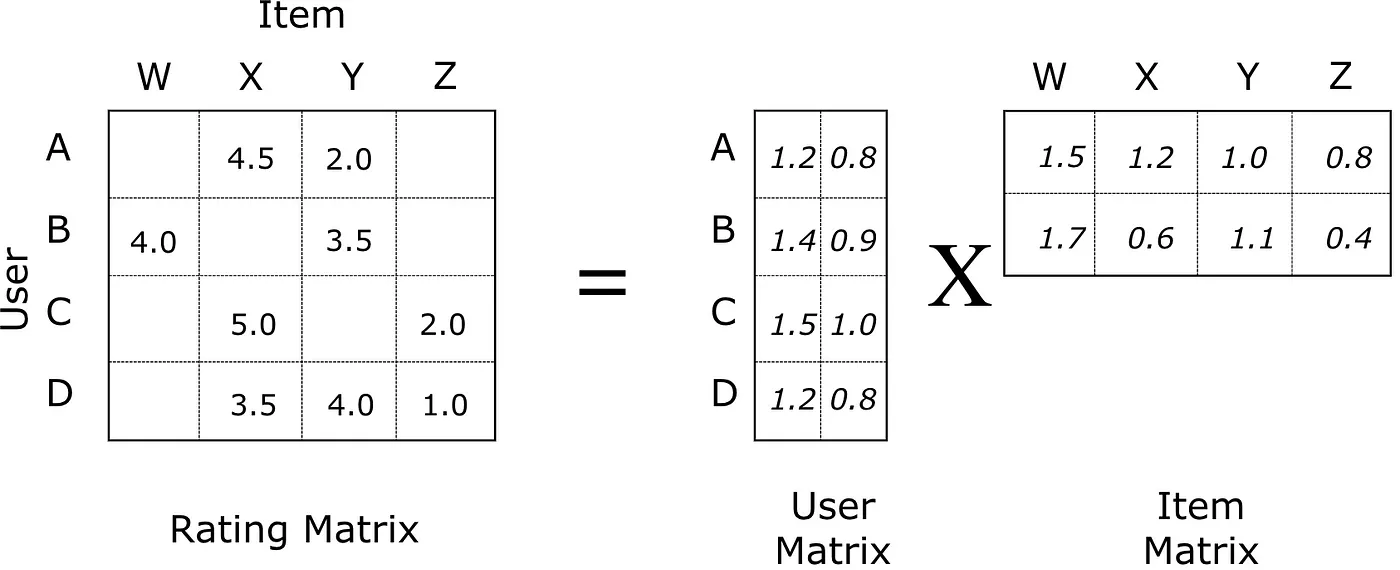

#### Inicialização
Primeiro, inicializamos aleatoriamente as matrizes P e Q com valores numéricos (geralmente pequenos) para os vetores latentes (ou fatores latentes) dos usuários e itens, respectivamente. O número de fatores latentes é um hiperparâmetro do algoritmo e precisa ser definido antecipadamente.

#### Alternância de mínimos quadrados:
O nome "Alternating Least Squares" vem da abordagem de minimizar os erros quadráticos de forma alternada. Inicialmente, fixamos a matriz de itens (Q) e otimizamos a matriz de usuários (P) para reduzir o erro de reconstrução das avaliações originais. Em seguida, fixamos a matriz de usuários e otimizamos a matriz de itens para reduzir o erro ainda mais.

- a. Otimização de P (usuários fixos):

Para otimizar a matriz P, fixamos a matriz Q e minimizamos a soma dos quadrados dos erros entre os valores reais da matriz R e os valores preditos pela multiplicação de P e Q transposta.
Utilizamos  Gradiente Descendente para ajustar os vetores latentes dos usuários na matriz P de forma a reduzir os erros entre as previsões e as avaliações reais. Isso é feito tomando a derivada parcial da função de perda em relação a $p_{ij}$ e igualando a zero:
$$\frac{\partial Loss}{\partial p_{ij}} = -2\sum_{(i,j)\in \Omega}\left (r_{ij}-\hat{r}_{ij} \right )q_{jk} = 0$$
$$\sum_{(i,j)\in \Omega}r_{ij}q_{jk} = \sum_{(i,j)\in \Omega}\hat{r}_{ij}q_{jk}$$
E agora resolvemos para $p_{ik}$ para cada k para otimizar a matriz P. 

- b. Otimização de Q (itens fixos):

Em seguida, fixamos a matriz P e otimizamos a matriz Q usando o mesmo processo de minimização da soma dos quadrados dos erros.
Ajustamos os vetores latentes dos itens na matriz Q para que as previsões da multiplicação de P e Q transposta se aproximem o máximo possível das avaliações reais da matriz R. Tomamos a derivada parcial da função de perda em relação a $q_{jk}$ e igualamos a zero:
$$\frac{\partial Loss}{\partial q_{ij}} = -2\sum_{(i,j)\in \Omega}\left (r_{ij}-\hat{r}_{ij} \right )p_{ik} = 0$$
$$\sum_{(i,j)\in \Omega}r_{ij}p_{jk} = \sum_{(i,j)\in \Omega}\hat{r}_{ij}p_{ik}$$
E ai resolvemos para $q_{jk}$ para cada k para otimizar a matriz Q. 
#### Convergência:
O algoritmo itera essas duas etapas de alternância até que a matriz de usuários e a matriz de itens atinjam um ponto de convergência, ou seja, até que as predições das avaliações se aproximem o máximo possível das avaliações reais dadas pelos usuários.

#### Geração de recomendações:
Após obtermos as matrizes de usuários e itens otimizadas, podemos usá-las para fazer previsões sobre as avaliações que um usuário daria a um jogo específico. Com base nessas previsões, podemos recomendar os jogos mais bem avaliados que o usuário ainda não tenha experimentado.

#### Criando uma baseline

Umas das melhores baselines que podemos usar para comparar com o o nosso sistema de recomendação é um  baseado em popularidade. E isso é bastante simples de fazer: Basta definir o número de fatores latentes do algoritmo ALS para 1. Vamos entender por que isso acontece:

O modelo ALS com apenas 1 fator latente significa que o sistema está representando os usuários e os itens em um espaço de uma única dimensão. Isso implica que o modelo não está aprendendo características latentes complexas ou relacionamentos entre os usuários e os itens. Em vez disso, ele está considerando apenas uma única dimensão geral que captura a tendência média dos dados de avaliação.

Nesse caso, a matriz de avaliações é aproximada por uma matriz de produtos externos (ou seja, apenas um único produto externo) dos vetores de usuário e item. Como resultado, o modelo está simplesmente ponderando as preferências dos usuários e as características dos itens pelo mesmo valor escalar, o que torna o processo de recomendação muito simplificado.

Se todos os usuários têm avaliações semelhantes ou idênticas para um item específico, o modelo ALS com 1 fator latente irá classificar esse item como popular, porque o único fator latente será igualmente aplicado a todos os usuários, sem levar em consideração suas preferências individuais.

#### Regularização

Na função de perda, o Spark  implementa regularização ao ALS, para controlar o overfitting e melhorar o desempenho geral do sistema de recomendação.  A regularização é uma técnica que penaliza os termos de alta magnitude nas matrizes P e Q durante a otimização, incentivando os vetores latentes a terem valores menores e, assim, evitando que o modelo se ajuste excessivamente aos dados de treinamento.
Existem dois tipos comuns de regularização que podem ser adicionados ao ALS: a regularização L2 (também conhecida como regularização Ridge) e a regularização L1 (também conhecida como regularização LASSO). A diferença entre elas está na forma como a penalização é aplicada.
- Regularização L2 (Ridge):
A regularização L2 adiciona um termo à função de perda que é proporcional à soma dos quadrados dos elementos das matrizes P e Q. O objetivo é forçar os valores dos vetores latentes a serem pequenos. A função de perda com regularização L2 é dada por:
$$Loss_{L2} = \sum_{(i,j)\in \Omega}\left (r_{ij}-\hat{r}_{ij} \right )^{2}+\lambda\left(\sum_{i=1}^{M}\sum_{k=1}^{K}p_{ik}^{2}+\sum_{j=1}^{N}\sum_{k=1}^{K}q_{jk}^{2}\right)$$
onde $\lambda$ é o parâmetro de regularização L2 que controla a força da penalização. Quanto maior o valor de $\lambda$, maior a penalização e mais fortemente os vetores latentes serão regularizados.

- Regularização L1 (LASSO):
A regularização L1 adiciona um termo à função de perda que é proporcional à soma dos valores absolutos dos elementos das matrizes P e Q. Assim como a regularização L2, a regularização L1 também incentiva os vetores latentes a terem valores menores, mas de uma maneira mais esparsa. A função de perda com regularização L1 é dada por:
$$Loss_{L1} = \sum_{(i,j)\in \Omega}\left (r_{ij}-\hat{r}_{ij} \right )^{2}+\lambda\left(\sum_{i=1}^{M}\sum_{k=1}^{K}\left| p_{ik}\right|+\sum_{j=1}^{N}\sum_{k=1}^{K}\left|q_{jk}\right|\right)$$
Quanto maior o valor de $\lambda$, mais esparsos os vetores latentes se tornam.

### Usando ALS com Spark

Configuramos o modelo ALS da seguinte forma:

- userCol: Especifica o nome da coluna que contém os índices dos usuários.
- itemCol: Especifica o nome da coluna que contém os índices dos itens (jogos, no caso).
- ratingCol: Especifica o nome da coluna que contém as avaliações dos usuários para os itens.
- coldStartStrategy: Especifica a estratégia para lidar com novos usuários ou itens durante a previsão. Neste caso, "drop" indica que os novos usuários ou itens serão descartados.
- nonnegative: Indica se as previsões devem ser restritas a valores não negativos.

Depois é criado um grid de hiperparâmetros para o ALS usando a classe ParamGridBuilder. Aqui, três hiperparâmetros estão sendo especificados:

- rank: Especifica o número de fatores latentes (também chamados de dimensões) do ALS.
- maxIter: Especifica o número máximo de iterações que o ALS pode executar durante o treinamento.
- regParam: Especifica o termo de regularização que controla a força da penalização para evitar overfitting.

Um avaliador de regressão é criado para avaliar o desempenho do modelo ALS. O avaliador utilizará a métrica "rmse" (Root Mean Squared Error) para calcular o erro entre as avaliações reais e as previsões do modelo. 
O objeto CrossValidator é criado para realizar a validação cruzada. Ele usa o grid de hiperparâmetros param_grid, o avaliador evaluator e divide os dados em 3 folds para avaliar o desempenho do modelo.

In [11]:
# Configurar o modelo ALS
als = ALS(userCol='userIndex', itemCol='itemIndex', ratingCol='rating',
          coldStartStrategy='drop', nonnegative=True)


param_grid = ParamGridBuilder()\
             .addGrid(als.rank, [1, 30])\
             .addGrid(als.maxIter, [20])\
             .addGrid(als.regParam, [.15])\
             .build()
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

cv = CrossValidator(
        estimator=als,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=3)

model = cv.fit(train_df_rec)

In [12]:
model.avgMetrics[0]

1.0510161267562588

In [13]:
best_model = model.bestModel

In [14]:
print('rank: ', best_model.rank)
print('MaxIter: ', best_model._java_obj.parent().getMaxIter())
print('RegParam: ', best_model._java_obj.parent().getRegParam())

rank:  1
MaxIter:  20
RegParam:  0.15


In [15]:
# Train the model using the training data
model = als.fit(train_df_rec)

# Generate predictions on the test data
predictions = best_model.transform(test_df_rec)
predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 1 THEN 1 WHEN prediction > 5 THEN 5 ELSE prediction END"))

evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 1.0235167809505221


Com o modelo treinado, geraremos as top 100 recomendações de itens para cada usuário, filtrando os itens que já estão na base de treino

In [16]:
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.sql.functions import col, collect_list

# Convert the predictions DataFrame to include all predictions per user
# Generate top-k recommendations for each user
userRecs = best_model.recommendForAllUsers(100)  # Top-100 recommendations for each user

# Prepare the input for RankingMetrics
user_ground_truth = test_df_rec.groupby('userIndex').agg(collect_list('itemIndex').alias('ground_truth_items'))
user_train_items = train_df_rec.groupby('userIndex').agg(collect_list('itemIndex').alias('train_items'))

# Join the recommendations and ground truth data on the user ID
user_eval = userRecs.join(user_ground_truth, on='userIndex').join(user_train_items, on='userIndex') \
    .select('userIndex', 'recommendations.itemIndex', 'ground_truth_items', 'train_items', 'recommendations.rating')
user_eval = user_eval.toPandas()
user_eval['itemIndex_filtered'] = user_eval.apply(lambda x:[b for (b,z) in zip(x.itemIndex, x.rating) if b not in x.train_items], axis=1)
user_eval['rating_filtered'] = user_eval.apply(lambda x:[z for (b,z) in zip(x.itemIndex, x.rating) if b not in x.train_items], axis=1)

In [17]:
user_eval

,userIndex,itemIndex,ground_truth_items,train_items,rating,itemIndex_filtered,rating_filtered
0,148,"[166, 216, 489, 414, 426, 217, 158, 177, 290, ...","[82, 206, 237, 224, 194, 95]","[101, 281, 281, 19, 19, 181, 250, 280, 328, 86...","[4.379154205322266, 4.263757228851318, 4.18894...","[166, 216, 489, 414, 426, 217, 177, 290, 31, 4...","[4.379154205322266, 4.263757228851318, 4.18894..."
1,463,"[166, 216, 489, 414, 426, 217, 158, 177, 290, ...","[289, 221, 29, 35]","[23, 179, 7, 216, 112, 88, 106, 140, 18, 196]","[5.478390216827393, 5.33402681350708, 5.240432...","[166, 489, 414, 426, 217, 158, 177, 290, 31, 4...","[5.478390216827393, 5.2404327392578125, 5.2285..."
2,471,"[166, 216, 489, 414, 426, 217, 158, 177, 290, ...","[333, 141, 90, 89]","[88, 18, 12, 362, 372, 91, 99, 324, 324, 8]","[5.761139392852783, 5.609324932098389, 5.51090...","[166, 216, 489, 414, 426, 217, 158, 177, 290, ...","[5.761139392852783, 5.609324932098389, 5.51090..."
3,496,"[166, 216, 489, 414, 426, 217, 158, 177, 290, ...","[4, 67, 441]","[51, 235, 116, 371, 58, 212, 109, 6, 6, 8]","[5.324218273162842, 5.183917045593262, 5.09295...","[166, 216, 489, 414, 426, 217, 158, 177, 290, ...","[5.324218273162842, 5.183917045593262, 5.09295..."
4,833,"[166, 216, 489, 414, 426, 217, 158, 177, 290, ...","[25, 386, 134]","[4, 88, 55, 200, 34, 18, 51, 62]","[5.145674705505371, 5.010078430175781, 4.92216...","[166, 216, 489, 414, 426, 217, 158, 177, 290, ...","[5.145674705505371, 5.010078430175781, 4.92216..."
...,...,...,...,...,...,...,...
7487,6721,"[166, 216, 489, 414, 426, 217, 158, 177, 290, ...",[17],"[57, 47, 69, 79]","[5.573663234710693, 5.426788806915283, 5.33156...","[166, 216, 489, 414, 426, 217, 158, 177, 290, ...","[5.573663234710693, 5.426788806915283, 5.33156..."
7488,6819,"[166, 216, 489, 414, 426, 217, 158, 177, 290, ...",[258],"[165, 127, 7, 140]","[5.357548713684082, 5.216369152069092, 5.12483...","[166, 216, 489, 414, 426, 217, 158, 177, 290, ...","[5.357548713684082, 5.216369152069092, 5.12483..."
7489,7166,"[166, 216, 489, 414, 426, 217, 158, 177, 290, ...",[106],"[115, 355, 68, 310]","[5.5032734870910645, 5.3582539558410645, 5.264...","[166, 216, 489, 414, 426, 217, 158, 177, 290, ...","[5.5032734870910645, 5.3582539558410645, 5.264..."
7490,7466,"[166, 216, 489, 414, 426, 217, 158, 177, 290, ...",[80],"[156, 277, 23, 153]","[3.7989935874938965, 3.6988844871520996, 3.633...","[166, 216, 489, 414, 426, 217, 158, 177, 290, ...","[3.7989935874938965, 3.6988844871520996, 3.633..."


### Métricas de avaliação

Há diversas métricas que podemos utilizar para avaliar sistemas de recomendação. Essas métricas medem diferentes aspectos do desempenho do sistema e são úteis para entender como as recomendações se comparam às preferências e interesses reais dos usuários.

- Precision@k:
A precisão@k é uma métrica que mede a proporção de itens relevantes que foram recomendados nos primeiros k itens da lista de recomendação. Ela foca na taxa de acerto das recomendações em relação ao número total de itens recomendados.
A fórmula para calcular a precisão@k é a seguinte:
$$Precision@k = \frac{\text{relevant itens in the first k positions}}{k}$$
Aqui, "itens relevantes" são os itens que o usuário interagiu positivamente ou avaliou com alta pontuação. Portanto, a precisão@k mede a capacidade do sistema de recomendação em fornecer recomendações relevantes nos primeiros k itens da lista.

- Recall@k:
O recall@k é uma métrica que mede a proporção de itens relevantes que foram recomendados em relação ao número total de itens relevantes na base de dados. Diferentemente da precisão@k, o recall@k foca na taxa de recuperação de itens relevantes entre todos os itens relevantes disponíveis.
A fórmula para calcular o recall@k é a seguinte:

$$Recall@k = \frac{\text{relevant itens in the first k positions}}{\text{total relevant itens}}$$
O recall@k é importante para avaliar se o sistema de recomendação está sendo capaz de recuperar todos os itens relevantes em sua lista de recomendação, independentemente da ordem.

- NDCG (Normalized Discounted Cumulative Gain):
O NDCG é uma métrica que leva em consideração a relevância dos itens recomendados e a posição em que eles foram recomendados. Ela valoriza as recomendações relevantes que estão mais próximas do topo da lista de recomendação, atribuindo maior pontuação para itens relevantes em posições superiores.
A fórmula para calcular o NDCG é a seguinte:
$$ NDCG@k = \frac{DCG@k}{IDCG@k}$$
onde DCG@k (Discounted Cumulative Gain) é calculado como:
$$DCG@k = \sum_{i=1}^{k}\frac{2^{rel_{i}}-1}{log_{2}(i+1)}$$
e IDCG@k (Ideal Discounted Cumulative Gain) é o valor DCG@k ideal, obtido quando todos os k itens recomendados são relevantes.

O NDCG@k varia entre 0 e 1, onde 1 indica que todas as recomendações são perfeitamente relevantes e estão posicionadas no topo da lista.

Usamos cada uma dessa métricas, usaremos como itens relevantes os itens mascarados da base de teste. Caso o sistema tenha recomendado 2 itens que estavam na base de teste do usuário nas 5 primeiras posições, seu precision@5 é 2/5. Se esse usuário tinha 7 itens mascarados, o recall@5 é 2/7. 
Caso um sistema de recomendação tenham colocados esse itens em primeiro e segundo lugar e outro sistema em quarto e quinto, a precision@k será a mesma, mas o NDCG leva em consideração a posição dos itens, penalizando posições mais baixas. Portanto, o NDCG@5 para o primeiro sistema de recomendação é aproximadamente 1.00, indicando que todas as recomendações relevantes estão posicionadas nas melhores posições. Já o NDCG@5 para o segundo sistema de recomendação é aproximadamente 0.55, indicando que as recomendações relevantes estão posicionadas abaixo do que o sistema ideal poderia fornecer. Um NDCG@5 de 1.00 é o valor ideal, indicando que todas as recomendações relevantes estão nas melhores posições e têm alta relevância.


De maneira geral, avaliaremos o sistema de recomendação usando o NDCG médio, que calcula a média do NDCG para todos os usuários no conjunto de testes. e o Average Mean Precision (MAP). O MAP é uma medida resumida da precisão em diferentes pontos de corte (k) na lista de recomendação. Para calcular o MAP, primeiro é necessário calcular a Precisão Média para cada usuário. A Precisão Média é uma métrica que considera a relevância dos itens recomendados ao longo da lista de recomendação. Ela mede a proporção de itens relevantes encontrados em cada posição da lista de recomendação até o item k, e a média dessas proporções é calculada para cada usuário. Em seguida, o MAP é calculado como a média das Precisões Médias para todos os usuários no conjunto de testes.

Uma implementação em python é mostrada abaixo:

In [18]:
import numpy as np
import math
def score(predicted, actual, metric):
        """
        Parameters
        ----------
        predicted : List
            List of predicted apps.
        actual : List
            List of masked apps.
        metric : 'precision' or 'ndcg'
            A valid metric for recommendation.
        Raises
        -----
        Returns
        -------
        m : float
            score.
        """
        valid_metrics = ['precision', 'ndcg']
        if metric not in valid_metrics:
            raise Exception(f"Choose one valid baseline in the list: {valid_metrics}")
        if metric == 'precision':
            m = np.mean([float(len(set(predicted[:k]) 
                                               & set(actual))) / float(k) 
                                     for k in range(1,len(actual)+1)])
        if metric == 'ndcg':
            v = [1 if i in actual else 0 for i in predicted]
            v_2 = [1 for i in actual]
            dcg = sum([(2**i-1)/math.log(k+2,2) for (k,i) in enumerate(v)])
            idcg = sum([(2**i-1)/math.log(k+2,2) for (k,i) in enumerate(v_2)])
            m = dcg/idcg
        return m

In [19]:
user_eval['precision'] = user_eval.apply(lambda x: score(x.itemIndex_filtered, x.ground_truth_items, 'precision'), axis=1)

In [20]:
user_eval['NDCG'] = user_eval.apply(lambda x: score(x.itemIndex_filtered, x.ground_truth_items, 'ndcg'), axis=1)

In [21]:
user_eval.precision.mean()

0.012509945893025315

In [22]:
user_eval.NDCG.mean()

0.056441136982131455

In [23]:
user_predictions_and_ground_truth_rdd = spark.sparkContext.parallelize(user_eval.values.tolist())\
                                             .map(lambda x: (x[5], x[2], x[6]))

rank_metrics = RankingMetrics(user_predictions_and_ground_truth_rdd)

# Evaluate precision at k
k = 3
precision_at_k = rank_metrics.precisionAt(k)
print(f'Precision at {k}: {precision_at_k}')

# Evaluate recall at k
recall_at_k = rank_metrics.recallAt(k)
print(f'Recall at {k}: {recall_at_k}')

# Evaluate NDCG at k
ndcg_at_k = rank_metrics.ndcgAt(k)
print(f'NDCG at {k}: {ndcg_at_k}')

C:\Users\bruno\anaconda3\Lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision at 3: 0.00814201815269621
Recall at 3: 0.014879409128274587
NDCG at 3: 0.014710266961911753


In [24]:
for k in range(1,10):
    precision_at_k = rank_metrics.precisionAt(k)
    print(f'Precision at {k}: {precision_at_k}')

Precision at 1: 0.013881473571809931
Precision at 2: 0.011278697277095568
Precision at 3: 0.008142018152696212
Precision at 4: 0.00644020288307528
Precision at 5: 0.005232247730912973
Precision at 6: 0.005917423029008721
Precision at 7: 0.005110212798413548
Precision at 8: 0.004588227442605447
Precision at 9: 0.004627157857269978


In [25]:
for k in range(1,10):
    ndcg_at_k = rank_metrics.ndcgAt(k)
    print(f'NDCG at {k}: {ndcg_at_k}')

NDCG at 1: 0.013881473571809931
NDCG at 2: 0.014875431489119396
NDCG at 3: 0.014710266961911755
NDCG at 4: 0.014677103920590025
NDCG at 5: 0.014613593865038802
NDCG at 6: 0.016678262581709333
NDCG at 7: 0.01667356407796003
NDCG at 8: 0.016851420000452436
NDCG at 9: 0.017764452296611843


In [26]:
import pandas as pd
from surprise import Dataset, Reader, KNNWithMeans, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Assuming you have a DataFrame named 'train_df' with columns: 'user_id', 'item_id', 'rating'
# Create a Reader object to specify the rating scale (here, assumed to be from 1 to 5)
reader = Reader(rating_scale=(1, 5))
train_df = Dataset.load_from_df(train_df_rec.toPandas()[['userIndex', 'itemIndex', 'rating']], reader)
test_df = Dataset.load_from_df(test_df_rec.toPandas()[['userIndex', 'itemIndex', 'rating']], reader)
# Load the data from the DataFrame into the Surprise Dataset
#train_data = Dataset.load_from_df(train_df[['userId', 'itemId', 'rating']], reader)

trainset = train_df.build_full_trainset()
testset = test_df.build_full_trainset().build_testset()

# Split the data into train and test sets
#trainset, testset = train_test_split(train_data, test_size=0.2, random_state=42)

# Train the model (you can choose a different model as well)
model = SVD(n_factors=50, biased=True, random_state=42)
model.fit(trainset)

# Evaluate the model on test data using precision@k and recall@k with k=10
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)  # Assuming a threshold of 4 for relevant items

# Print the precision@k and recall@k scores
print(f"rmse: {rmse}")

ModuleNotFoundError: No module named 'surprise'

In [ ]:
a = user_ground_truth.toPandas()

In [ ]:
a

In [ ]:
b = user_predictions_and_ground_truth.toPandas()

In [ ]:
b